# PySP开发测试区

## 0. 测试准备

### 0.1 测试环境导入

In [5]:
import numpy as np
from numpy import random
from scipy.io import loadmat
import os

### 0.2 测试数据导入

> 测试数据1: 故障轴承振动信号

In [6]:
import pandas as pd
import numpy as np
import os


# --------------------------------------------------------------------------------------------#
# -## ----------------------------------------------------------------------------------------#
# -----## ------------------------------------------------------------------------------------#
# ---------## --------------------------------------------------------------------------------#
def readData(type: str, level: str, fr: str, load: str, FileLoc: str):
    """
    读取创新港实验台轴承振动数据集

    参数:
    ----------
    type: str
        故障类型, 可选值: ["保持架", "滚动体", "内圈", "外圈", "正常"]
    level: str
        故障等级, 可选值: ["轻度", "中度", "重度"] 或 ["0.25", "0.5", "0.75"]
    fr: str
        转子转速, 可选值: ["500", "1000", "1500", "1680", "1860", "2000", "2500"]
    load: str
        负载, 可选值: ["0", "0.4", "0.8", "1.2"]
    FileLoc: str
        数据集文件夹路径

    返回:
    ----------
    info: DataFrame
        数据信息表
    """
    # 数据集文件信息
    type_list = ["保持架", "滚动体", "内圈", "外圈", "正常"]
    level_dict = {
        "保持架": ["轻度", "中度", "重度"],
        "滚动体": ["轻度", "中度", "重度"],
        "内圈": ["0.25", "0.5", "0.75"],
        "外圈": ["0.25", "0.5", "0.75"],
        "正常": ["0.25", "0.5", "0.75"],
    }
    fr_list = ["500", "1000", "1500", "1680", "1860", "2000", "2500"]
    load_list = ["0", "0.4", "0.8", "1.2"]
    file = ""
    file_name = ""
    # ---------------------------------------------------------------------------------------#
    # 生成文件夹路径
    file = FileLoc + "\\"
    # 故障类型参数
    if type not in type_list:
        raise ValueError(f"故障类型参数'type'错误, 可选值: {type_list}")
    else:
        file += type + "\\"
    # 故障等级参数
    if level not in level_dict[type]:
        raise ValueError(f"故障等级参数'level'错误, 可选值: {level_dict[type]}")
    else:
        file += level + "\\"
    # 转子转速参数
    if fr not in fr_list:
        raise ValueError(f"转速参数'fr'错误, 可选值: {fr_list}")
    else:
        file += fr + "\\"
    # 负载参数
    if load not in load_list:
        raise ValueError(f"负载参数'load'错误, 可选值: {load_list}")
    else:
        file += load + "\\"
    # -----------------------------------------------------------------------------------#
    # 读取文件夹下所有数据
    print(f"尝试读取文件路径: {file}")
    try:
        file_list = os.listdir(file)
    except FileNotFoundError:
        raise FileNotFoundError("读取失败: 不存在该参数下实验数据文件")
    print("读取成功")
    # -----------------------------------------------------------------------------------#
    # 提取数据, 并生成数据信息表
    info = pd.DataFrame(
        columns=["点数", "采样频率", "采样时间", "数据/通道1", "数据/通道2", "文件路径"]
    )
    fs = 12000
    file_list = [
        file_name for file_name in file_list if file_name[-4:] != ".xls"
    ]  # 去除配置文件
    file_list = sorted(file_list)  # 按文件名时间顺序排序
    for i, file_name in enumerate(file_list):
        # 读取数据
        data = pd.read_csv(file + file_name, header=None, sep="\t")
        data = data.to_numpy().T  # 得到2*N的双通道数据
        info.loc[i] = [
            data.shape[1],
            fs,
            data.shape[1] / fs,
            data[0],
            data[1],
            file + file_name,
        ]
    return info


def readCHs(info: pd.DataFrame, channels: list) -> np.ndarray:
    """
    根据信息表读取指定通道的数据

    参数：
    ---------
    info: pd.DataFrame
        包含数据的信息表
    channels: list
        指定读取的通道列表, 格式: [1, 2, 5]
    
    返回：
    ---------
    dataArray: np.ndarray
        读取到的多通道数据, 形状为n * m * N, n为样本数量, m为通道数, N为单通道数据长度
    """
    # 构建通道列名
    channel_columns = [f"数据/通道{ch}" for ch in channels]
    # 读取指定通道的数据
    dataArray = np.array(
        [np.array(info.loc[i, channel_columns].to_list()) for i in info.index]
    )
    return dataArray

In [7]:
DataSet=readData(type="内圈", level="0.25", fr="500", load="0", FileLoc=r"F:\OneDrive\用户文件\科研学习\机械故障诊断数据库\CXG_bearing")
DataSet

尝试读取文件路径: F:\OneDrive\用户文件\科研学习\机械故障诊断数据库\CXG_bearing\内圈\0.25\500\0\
读取成功


,点数,采样频率,采样时间,数据/通道1,数据/通道2,文件路径
0,120000,12000,10.0,"[0.46971595, 0.65693538, -0.27106326, -0.74601...","[1.40867145, 1.4396365, -0.07765081, -1.186675...",F:\OneDrive\用户文件\科研学习\机械故障诊断数据库\CXG_bearing\内圈...
1,120000,12000,10.0,"[-1.14523036, -1.20430214, -1.21430623, -0.809...","[-0.24914953, 0.35585985, 0.22628304, -0.04668...",F:\OneDrive\用户文件\科研学习\机械故障诊断数据库\CXG_bearing\内圈...


In [8]:
Data=DataSet['数据/通道1'][0][:12000]
fs=int(DataSet['采样频率'][0])

## 1. Signal模块测试

### 1.1 Signal.Signal()

Signal(data=[ 0.46971595  0.65693538 -0.27106326 ... -0.80413845 -0.73029873
 -0.18388474], fs=12000, label=测试信号)


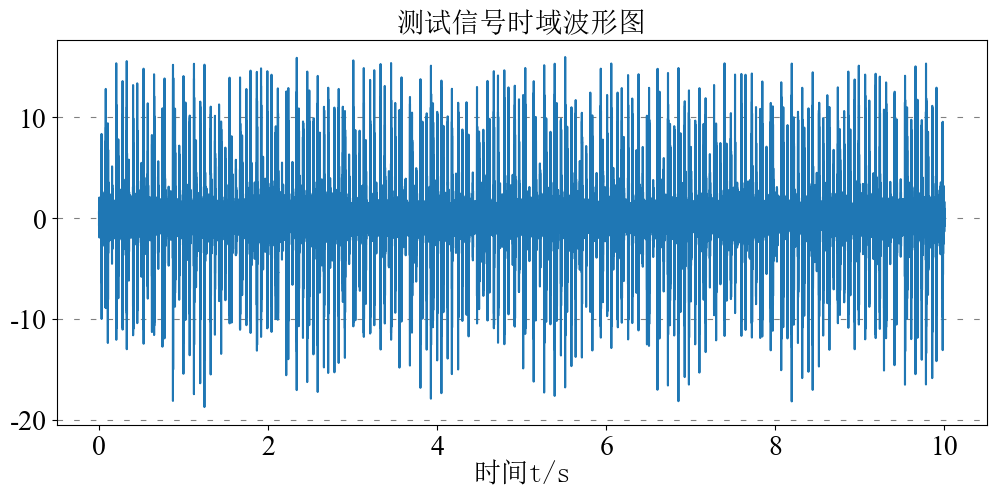

In [5]:
from PySP.Signal import Signal

try:
    res = Signal(data=Data, fs=fs, label="测试信号")
    print(repr(res))
    res.plot()
except Exception as e:
    print(e)

### 1.2 Signal.Resample()

Signal(data=[-10.70866606  -4.33558298   1.79025611 ...  -0.44875499  -0.50306292
   0.24248014], fs=6000.0, label=重采样测试信号)


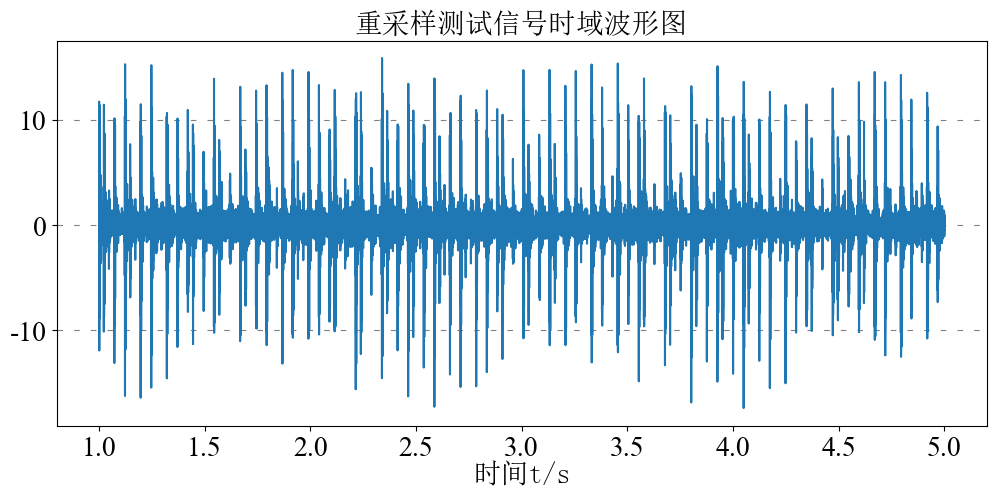

In [6]:
from PySP.Signal import Resample

try:
    res = Signal(data=Data,fs=12000,label='测试信号')
    res=Resample(Sig=res,down_fs=6000,t0=1,T=4)
    print(repr(res))
    res.plot()
except Exception as e:
    print(e)

### 1.3 Signal.Periodic()

Signal(data=[2.33897673 1.76852479 2.53286464 ... 0.09203118 0.99397599 1.92368336], fs=1000, label=仿真含噪准周期信号)


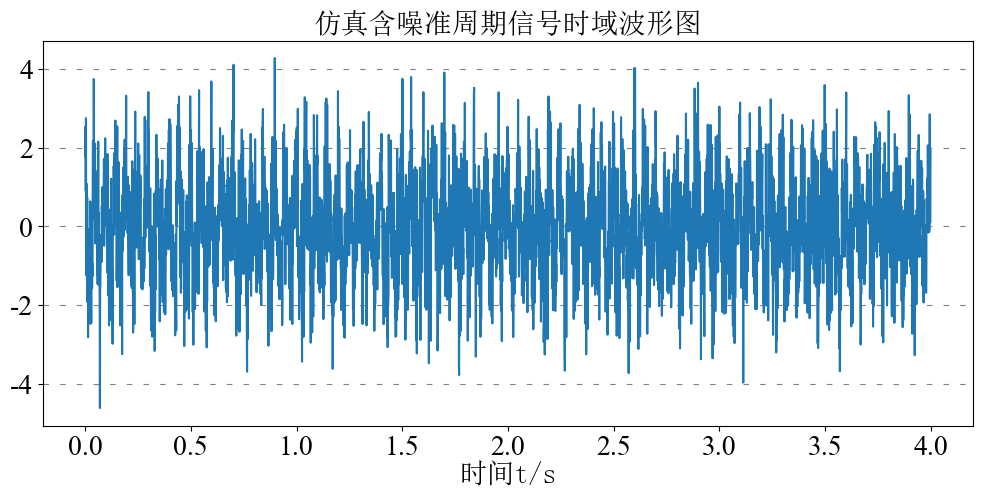

In [7]:
from PySP.Signal import Periodic

try:
    res = Periodic(fs=1000,T=4,CosParams=((20,1,32),(50,0.5,0)),noise=1)
    print(repr(res))
    res.plot()
except Exception as e:
    print(e)

### 1.4 Signal.Analysis()

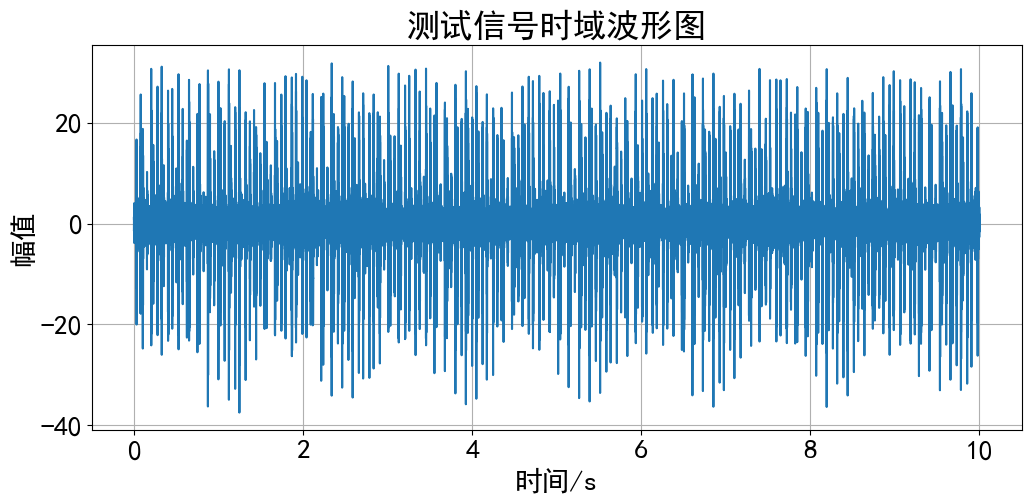

In [11]:
from PySP.Signal import Signal, Analysis
from matplotlib import pyplot as plt

try:

    class TestAnalysis(Analysis):
        @staticmethod
        def plot_scatter(Axis,data,**kwargs):
            plt.figure(figsize=(12, 5))
            plt.plot(Axis, data)
            plt.xlabel("时间/s")
            plt.ylabel("幅值")
            plt.title("测试信号时域波形图")
            plt.grid()
            plt.show()

        @Analysis.Plot(plot_func=plot_scatter)
        @Analysis.Input({"x": {"OpenLow": 0}})
        def run(self, x: float):
            t_Axis = self.Sig.t_Axis
            data = self.Sig.data * x
            return t_Axis, data

    Sig = Signal(data=Data, fs=fs, label="测试信号")
    res = TestAnalysis(
        Sig=Sig, plot=True, plot_save=False, xlabel="时间/s", title="测试信号时域波形图"
    ).run(x=2)

except Exception as e:
    print(e)

## 2. Plot模块测试

### 2.1 Plot.Plot()

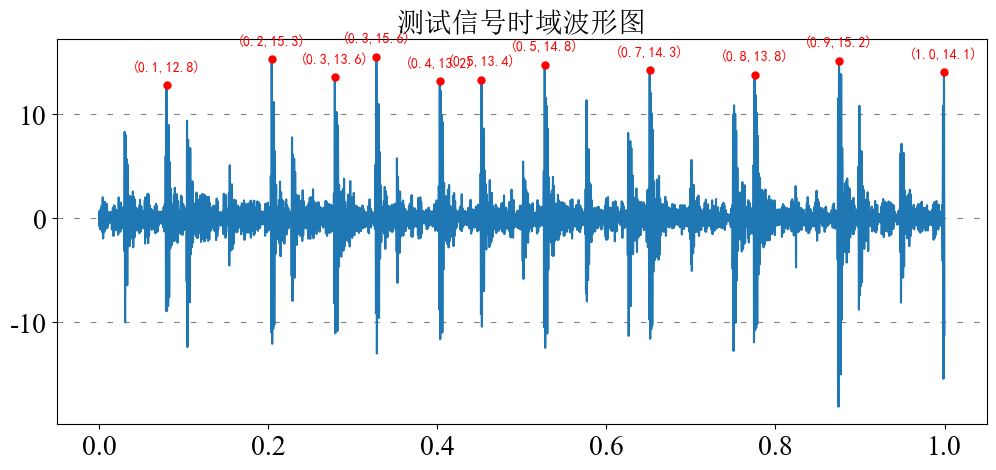

In [9]:
from PySP.Plot_new import LinePlot, PeakFinderPlugin
from PySP.Signal import Signal

try:
    res = Signal(data=Data, fs=fs, label="测试信号")
    Plot = LinePlot(title="测试信号时域波形图")
    Plot.add_plugin(PeakFinderPlugin(height=12, distance=100))
    Plot.plot(Axis=res.t_Axis, Data=res.data)
except Exception as e:
    print(e)

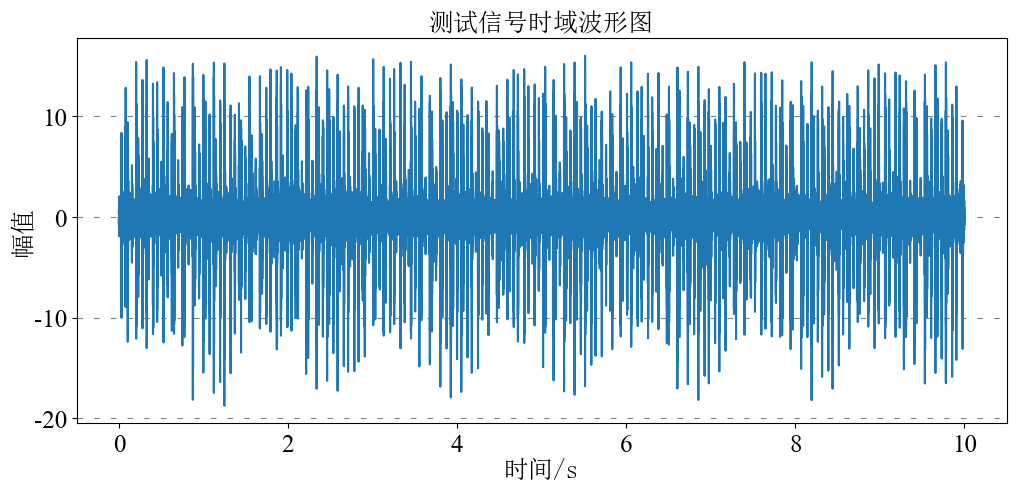

In [12]:
from PySP.Plot import plot

try:
    res = Signal(data=Data, fs=fs, label="测试信号")
    plot(res.t_Axis,res.data,xlabel="时间/s", ylabel="幅值", title="测试信号时域波形图",plot_save=True,plot_format="png")
except Exception as e:
    print(e)

### 2.2 Plot.imshow()

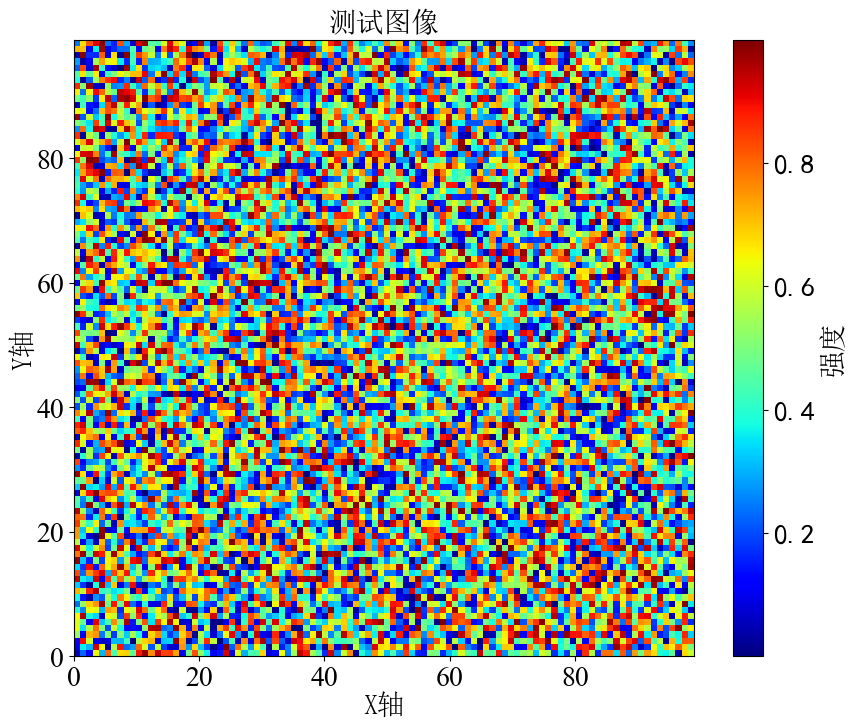

In [6]:
from PySP.Plot import imshow
from numpy import random

try:
    Axis1 = np.arange(100)
    Axis2 = np.arange(100)
    data= random.random((100,100))
    imshow(Axis1, Axis2, data, xlabel="X轴", ylabel="Y轴", title="测试图像", plot_save=True, plot_format="png",colorbarlabel= "强度")
except Exception as e:
    print(e)

### 2.3 Plot.plot_findpeaks()

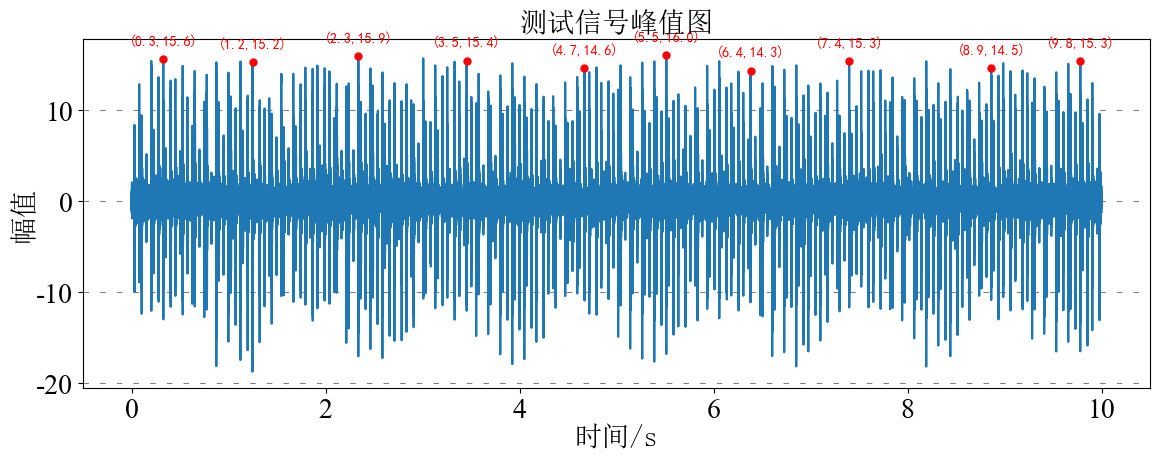

In [9]:
from PySP.Plot import plot_findpeaks
from PySP.Signal import Signal

try:
    res = Signal(data=Data, fs=fs, label="测试信号")
    plot_findpeaks(res.t_Axis,res.data,height=13,distance=10000,xlabel="时间/s", ylabel="幅值", title="测试信号峰值图")
except Exception as e:
    print(e)

## 3.BasicSP模块测试

### 3.1 BasicSP.window()

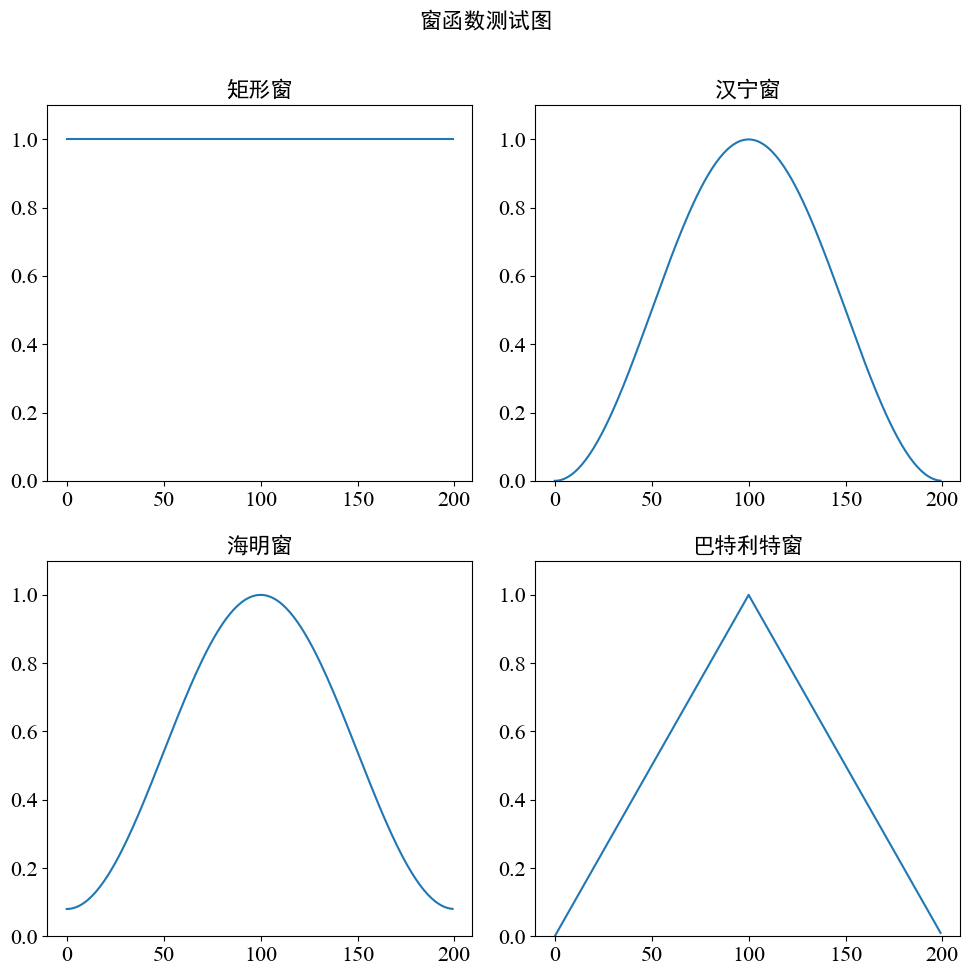

res1:  <class 'numpy.float64'>
res2:  <class 'numpy.float64'>
res3:  <class 'numpy.ndarray'>


In [21]:
from PySP.BasicSP import window

try:
    res=window(type="汉宁窗",num=200,padding=50,check=True)
    for i,r in enumerate(res):
        print(f"res{i+1}: ",type(r))
except Exception as e:
    print(e)

### 3.2 BasicSP.Time_Analysis()

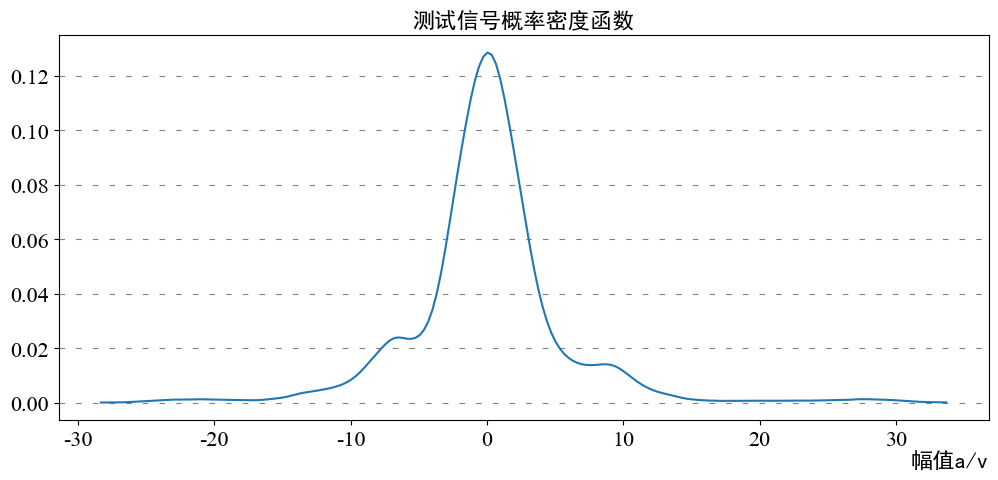

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


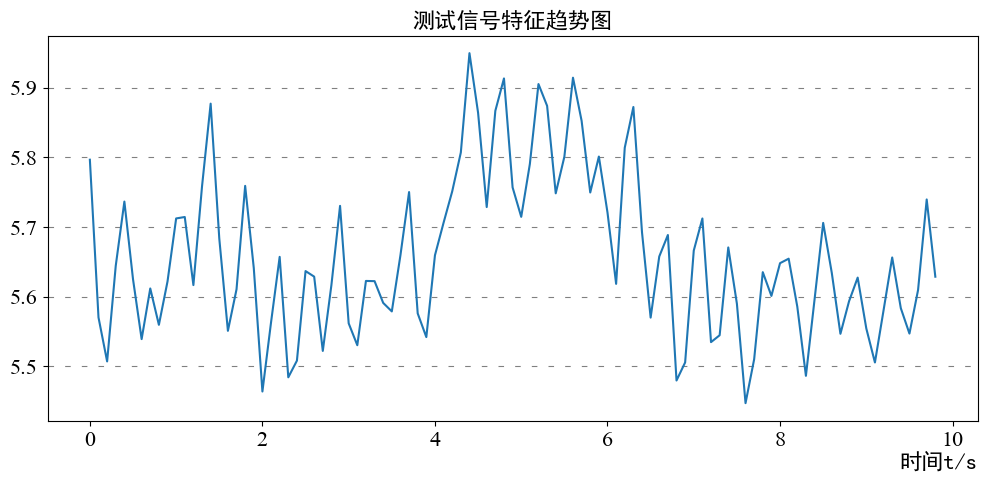

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


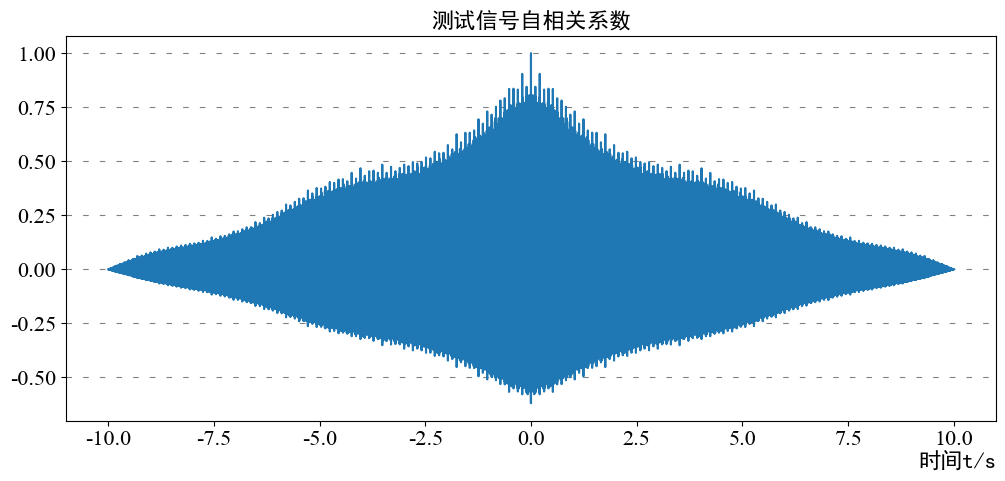

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


In [29]:
from PySP.BasicSP import Time_Analysis

try:
    Sig=Signal(data=Data,label='测试信号',fs=12000)
    # Time_Analysis.Psd()
    res=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"概率密度函数",xlabel="幅值a/v").Pdf(samples=200)
    for i, r in enumerate(res):
        print(f"res{i+1}: ", type(r))
    # Time_Analysis.Trend()
    res=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"特征趋势图",xlabel="时间t/s").Trend(Feature="有效值",step=0.1,SegLength=0.2)
    for i,r in enumerate(res):
        print(f"res{i+1}: ",type(r))
    # Time_Analysis.Autocorr()
    res=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"自相关系数",xlabel="时间t/s").Autocorr(std=True,both=True)
    for i,r in enumerate(res):
        print(f"res{i+1}: ",type(r))
except Exception as e:
    print(e)

### 3.3 BasicSP.Frequency_Analysis()

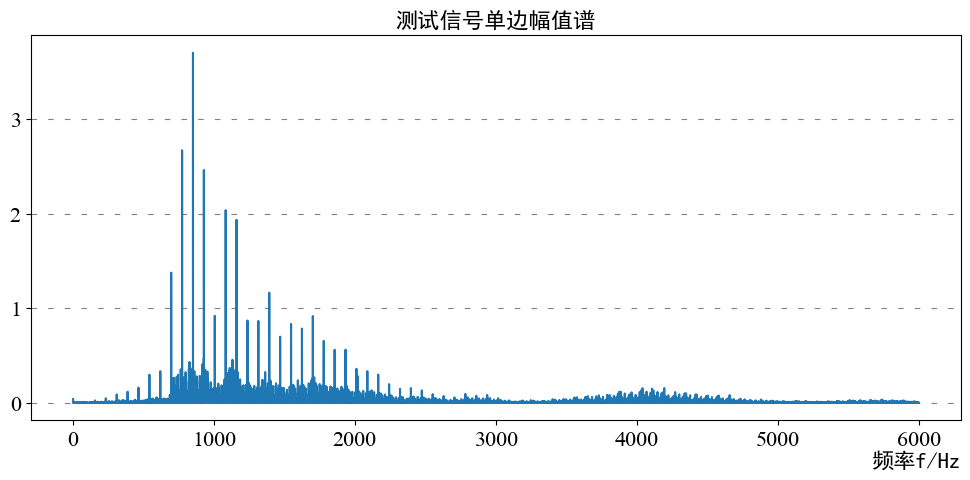

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


In [31]:
from PySP.BasicSP import Frequency_Analysis

try:
    Sig = Signal(data=Data, label="测试信号", fs=12000)
    # Frequency_Analysis.Cft()
    res = Frequency_Analysis(
        Sig=Sig,
        plot=True,
        plot_save=False,
        title=Sig.label + "单边幅值谱",
        xlabel="频率f/Hz",
    ).Cft(WinType="汉宁窗")
    for i, r in enumerate(res):
        print(f"res{i+1}: ", type(r))
except Exception as e:
    print(e)

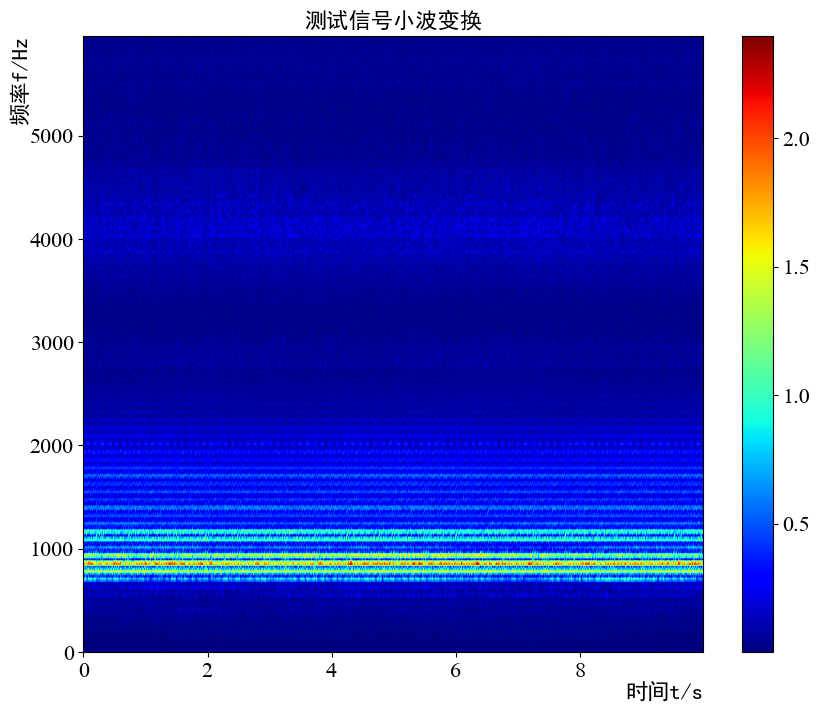

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>
res3:  <class 'numpy.ndarray'>


In [39]:
from PySP.BasicSP import TimeFre_Analysis

try:
    Sig = Signal(data=Data, label="测试信号", fs=12000)
    # TimeFre_Analysis.Wavelet()
    res = TimeFre_Analysis(
        Sig=Sig,
        plot=True,
        plot_save=False,
        title=Sig.label + "小波变换",
        xlabel="时间t/s",
        ylabel="频率f/Hz",
    ).st_Cft(nperseg=513, nhop=128,WinType="汉宁窗")
    for i, r in enumerate(res):
        print(f"res{i+1}: ", type(r))
except Exception as e:
    print(e)